In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 1. Load dataset
data = pd.read_csv("diabetes.csv")

In [3]:
# Replace invalid zeros with median
cols_with_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for col in cols_with_zero:
    data[col] = data[col].replace(0, np.nan)
    data[col].fillna(data[col].median(), inplace=True)

/tmp/ipython-input-1783219266.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [4]:
# Features / Target
X = data.drop("Outcome", axis=1).values
y = data["Outcome"].values

In [5]:
# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

In [8]:
# Dataloaders
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [9]:
# 2. Define Model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

model = NeuralNet()

In [10]:
# 3. Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# 4. Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {train_losses[-1]:.4f}")

Epoch 0, Loss: 0.7239
Epoch 10, Loss: 0.4614
Epoch 20, Loss: 0.4279
Epoch 30, Loss: 0.4362
Epoch 40, Loss: 0.4151
Epoch 50, Loss: 0.4115
Epoch 60, Loss: 0.4209
Epoch 70, Loss: 0.4163
Epoch 80, Loss: 0.3933
Epoch 90, Loss: 0.3896


In [12]:
# 5. Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_classes = (y_pred > 0.5).int()

print("\nClassification Report (PyTorch):")
print(classification_report(y_test, y_pred_classes))


Classification Report (PyTorch):
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.80       100
         1.0       0.62      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154



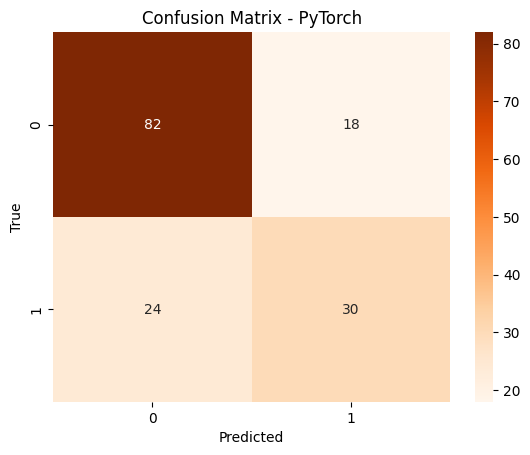

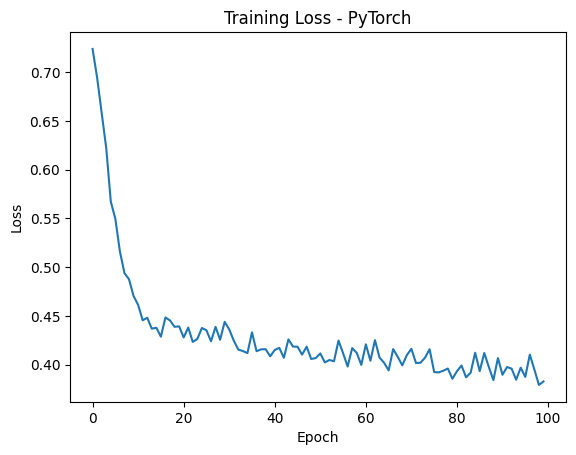

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - PyTorch")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss - PyTorch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()